In [41]:
import hypercontagion as hc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgi
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.patches import Patch

import fig_settings as fs

fs.set_fonts({"xtick.labelsize": 12, "ytick.labelsize": 12, "axes.labelsize": 12})

In [2]:
# H = xgi.read_hif("arxiv.json")

In [3]:
# words = ["hypergraph", "simplicial", "higher-order"]


# def isin(title, arg):
#     for w in arg:
#         if w.lower() in title.lower():
#             return True
#     return False


# higher_order_articles = H.edges.filterby_attr("title", words, mode=isin)

In [4]:
# SH = xgi.subhypergraph(H, edges=higher_order_articles).copy()
# SH = xgi.cut_to_order(SH, 2)
# SH.cleanup()

In [5]:
# xgi.write_hif(SH, "arxiv_higher_order.json")

In [42]:
SH = xgi.read_hif("arxiv_higher_order.json")

In [43]:
SH.num_nodes, SH.num_edges

(593, 518)

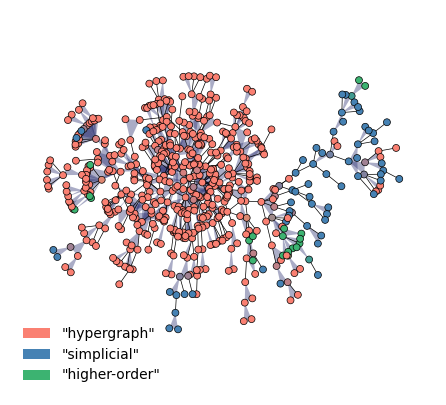

In [8]:
# node positions
pos = xgi.pca_transform(xgi.barycenter_kamada_kawai_layout(SH))

# node colors
words = ["hypergraph", "simplicial", "higher-order"]
colors = [
    np.array([0.9804, 0.502, 0.4471]),  # hypergraph
    np.array([0.2745, 0.5098, 0.7059]),  # simplicial
    np.array([0.2353, 0.702, 0.4431]),  # higher-order
]
node_color = {}
for n in SH.nodes:
    nbrs = SH.nodes.memberships(n)
    node_color[n] = np.zeros(3)  # Initialize color as black
    for e in nbrs:
        for i, w in enumerate(words):
            if w.lower() in SH.edges[e]["title"].lower():
                node_color[n] += colors[i] / len(nbrs)
                break
for n in SH.nodes:
    for i in range(3):
        node_color[n][i] = min(node_color[n][i], 1.0)

plt.figure(figsize=(5.5, 5))
xgi.draw(SH, pos=pos, node_lw=0.5, dyad_lw=0.5, node_size=5, node_fc=node_color)
legend_elements = [
    Patch(facecolor=colors[0], label=f'"{words[0]}"'),
    Patch(facecolor=colors[1], label=f'"{words[1]}"'),
    Patch(facecolor=colors[2], label=f'"{words[2]}"'),
]
plt.legend(handles=legend_elements, loc="best", fontsize=10, frameon=False)

plt.savefig("figures/dataset.svg", bbox_inches="tight", dpi=1000)

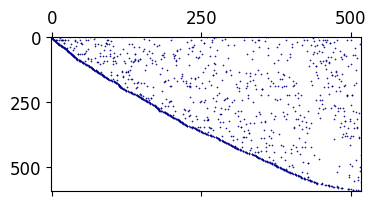

In [19]:
# incidence matrix
B = xgi.incidence_matrix(SH, sparse=False)
plt.figure(figsize=(4, 2))
plt.spy(B, aspect="auto", markersize=0.25, color="darkblue")
plt.xticks([0, 250, 500])
plt.yticks([0, 250, 500])
plt.savefig("figures/incidence_matrix.svg", bbox_inches="tight", dpi=1000)

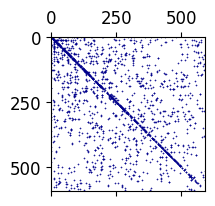

In [21]:
# adjacency matrix
A = xgi.adjacency_matrix(SH, sparse=False)
plt.figure(figsize=(2, 2))
plt.spy(A, markersize=0.25, color="darkblue")
plt.xticks([0, 250, 500])
plt.yticks([0, 250, 500])
plt.savefig("figures/adjacency_matrix.svg", bbox_inches="tight", dpi=1000)

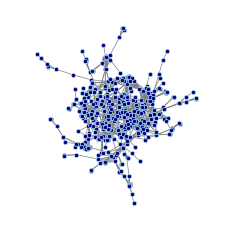

In [11]:
# line graph
plt.figure(figsize=(2.75, 2.75))
G = xgi.Hypergraph([[i, j] for i, j in xgi.to_line_graph(SH, s=1).edges])
pos_lg = xgi.pca_transform(xgi.pairwise_spring_layout(G, seed=1))
xgi.draw(
    G,
    pose=pos_lg,
    node_size=3,
    node_lw=0.5,
    node_fc="navy",
    node_ec="lightblue",
    dyad_lw=0.5,
    dyad_color="grey",
)
plt.savefig("figures/line_graph.svg", bbox_inches="tight", dpi=1000)

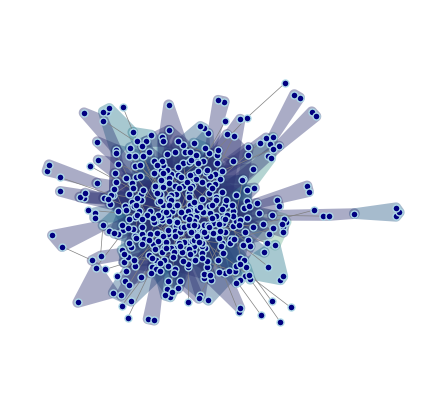

In [39]:
plt.figure(figsize=(5.5, 5))
# chung-lu hypergraph
k = SH.degree()
s = SH.size()

H_cl = xgi.chung_lu_hypergraph(k, s, seed=0)
H_cl.cleanup()
pos_new = xgi.pca_transform(xgi.pairwise_spring_layout(H_cl, seed=2))
xgi.draw(
    H_cl,
    pos=pos_new,
    node_size=5,
    node_fc="navy",
    node_ec="lightblue",
    dyad_lw=0.5,
    dyad_color="grey",
    hull=True,
    radius=0.03,
)
plt.savefig("figures/chung_lu.svg", bbox_inches="tight", dpi=1000)

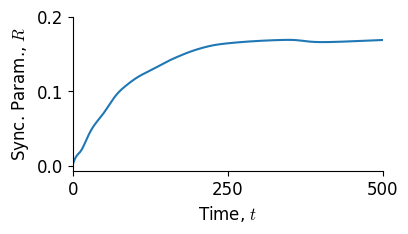

In [44]:
# kuramoto model
n = SH.num_nodes
omega = 2 * np.random.normal(1, 0.05, n)
theta = np.linspace(0, 2 * np.pi, n)
timesteps = 500
dt = 0.01
theta, t = xgi.simulate_kuramoto(
    SH, k2=2, k3=3, omega=omega, theta=theta, timesteps=timesteps, dt=dt
)
r = xgi.compute_kuramoto_order_parameter(theta)

plt.figure(figsize=(4, 2))
plt.plot(r)
plt.xlabel("Time, $t$")
plt.ylabel(r"Sync. Param., $R$")
plt.xlim([0, 500])
plt.xlim([0, 0.2])
plt.xticks([0, 250, 500])
plt.yticks([0, 0.1, 0.2])
sns.despine()
plt.savefig("figures/kuramoto.svg", bbox_inches="tight", dpi=1000)

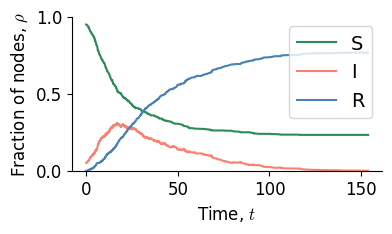

In [45]:
# SIR model
t, S, I, R = hc.Gillespie_SIR(SH, tau={2: 0.1, 3: 0.1}, gamma=0.05, rho=0.05, seed=0)
N = SH.num_nodes
plt.figure(figsize=(4, 2))
plt.plot(t, S / N, label="S", color="seagreen")
plt.plot(t, I / N, label="I", color="salmon")
plt.plot(t, R / N, label="R", color="steelblue")
plt.xlabel(r"Time, $t$")
plt.ylabel(r"Fraction of nodes, $\rho$")
plt.ylim([0, 1])
plt.yticks([0, 0.5, 1])
plt.xticks([0, 50, 100, 150])
plt.legend()
sns.despine()
plt.savefig("figures/sir.svg", bbox_inches="tight", dpi=1000)